In [3]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append("../")
import models
from utils.training import train_meta_model, train_gp
from utils.gp_data import obtain_me_a_nice_gp_dataset_please
from utils.data_utils import ctxt_trgt_split

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

### Make Dataset

In [46]:
num_datasets = 1000
md = []
data_hypers = {'l': 0.25, 'kernel': 'se', 'binary_2d': True, 'x_range': [-1.0, 1.0]}
for _ in range(num_datasets):
    X, y = obtain_me_a_nice_gp_dataset_please(n_range=[30, 150], **data_hypers)
    md.append((X, y))

### Initialise Models

In [ ]:
cnn_chans = [32, 32]
kernel_size = 3
Z_net_width = 32
Z_net_depth = 2
num_induc = 64
d_k = 8
grid_spacing = 1e-1

sconvsgnp = models.SparseGaussianNeuralProcess(
    x_dim=2,
    num_inducing=num_induc,
    likelihood=models.BernoulliLikelihood(),
    prior=models.GPPrior(covariance_function='squared-exponential', num_inputs=2, l=0.25, train_l=False, sigma_f=2.5, train_sigma_f=False),
    cnn_hidden_chans=cnn_chans,
    cnn_kernel_size=kernel_size,
    d_k=d_k,
    Z_net_width=Z_net_width,
    Z_net_hidden_depth=Z_net_depth,
    use_transformer=True,
    nonlinearity=torch.nn.ReLU(),
    use_titsias=True,
    sigma_y_tilde=0.5,
    train_sigma_y_tilde=False,
    const=2.0,
    grid_spacing=grid_spacing,
)

# convsgnp = models.SparseGaussianNeuralProcess(
#     x_dim=2,
#     num_inducing=num_induc,
#     likelihood=models.BernoulliLikelihood(),
#     prior=models.GPPrior(covariance_function='squared-exponential', num_inputs=2, l=0.25, train_l=False, sigma_f=2.5, train_sigma_f=False),
#     cnn_hidden_chans=cnn_chans, # ignored if using unet or titsias
#     cnn_kernel_size=kernel_size,
#     d_k=d_k,
#     Z_net_width=Z_net_width,
#     Z_net_hidden_depth=Z_net_depth,
#     use_transformer=True,
#     nonlinearity=torch.nn.ReLU(),
#     use_titsias=False,
#     grid_spacing=grid_spacing,
# )

# gnp = models.ConvGNP(
#     x_dim=2,
#     cnn_hidden_chans=cnn_chans,
#     cnn_kernel_size=kernel_size,
#     d_k=d_k,
#     nonlinearity=torch.nn.ReLU(),
#     grid_spacing=grid_spacing,
#     classification=True,
# )

### Train the Models

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/thomasrochussen/miniconda3/envs/torch-sandbox/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1728928937407/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10000/10000 [07:25<00:00, 22.42it/s, ll=-63.5, Epochs=1e+4] 


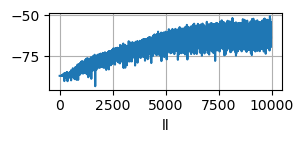

In [4]:
training_metrics = train_meta_model(
    gnp,
    md,
    training_steps=10_000,
    batch_size=5,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    num_samples=5,
    loss_function='npml',
    include_ctxt_in_trgt=True,
    ctxt_proportion_range=(0.05, 0.5),
)

fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
if not isinstance(axes, list):
    axes = [axes]
omitted_steps = 50
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

100%|██████████| 10000/10000 [28:57<00:00,  5.76it/s, elbo=-128, e_ll=-104, kl=23.7, Epochs=1e+4]    


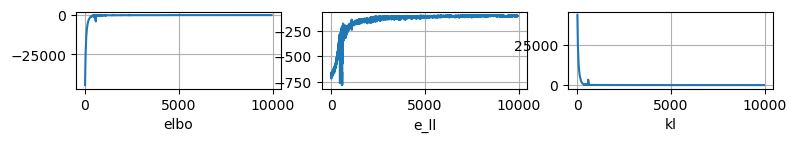

In [5]:
training_metrics = train_meta_model(
    convsgnp,
    md,
    training_steps=10_000,
    batch_size=5,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    num_samples=5,
    loss_function='vi',
)

fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
omitted_steps = 50
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

100%|██████████| 10000/10000 [19:19<00:00,  8.62it/s, elbo=-101, e_ll=-62, kl=38.8, Epochs=50]          


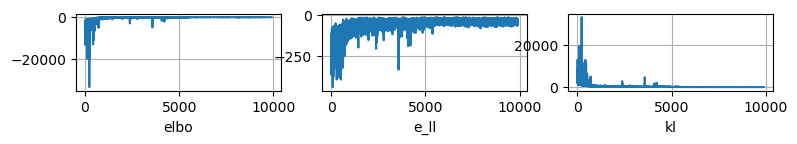

In [50]:
training_metrics = train_meta_model(
    sconvsgnp,
    md,
    training_steps=10_000,
    batch_size=5,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    num_samples=5,
    loss_function='vi',
)

fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
omitted_steps = 100
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

### Visualise test predictions

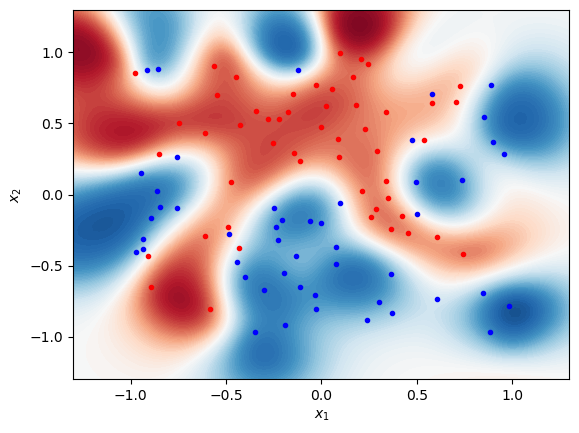

In [51]:
torch.manual_seed(100)
X, y = obtain_me_a_nice_gp_dataset_please(n_range=[100, 101], **data_hypers)
shift = 0.0
# X, y =  md[torch.randint(0, len(md), (1,)).item()]
X_c, y_c = X.clone(), y.clone()
t = y_c.squeeze()
scope=1.3

x_linspace = torch.linspace(data_hypers['x_range'][0]*scope, data_hypers['x_range'][1]*scope, 100)
xx1, xx2 = torch.meshgrid(x_linspace, x_linspace)
X_t = torch.cat((xx1.flatten().unsqueeze(1), xx2.flatten().unsqueeze(1)), dim=1)

with torch.no_grad():
    # preds = gnp(X_c, y_c, X_t).probs
    # preds = convsgnp(X_t, X_c, y_c).probs
    preds = sconvsgnp(X_t, X_c, y_c).probs
    
preds_grid = preds.reshape_as(xx1)

plt.contourf(xx1, xx2, 1-preds_grid, torch.linspace(0.0, 1.0, 100), cmap='RdBu')
plt.scatter(X_c[:,0][t == 1], X_c[:,1][t == 1], color='red', marker='.', label='Class 1')
plt.scatter(X_c[:,0][t == 0], X_c[:,1][t == 0], color='blue', marker='.', label='Class 0')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([data_hypers['x_range'][0]*scope, data_hypers['x_range'][1]*scope])
plt.ylim([data_hypers['x_range'][0]*scope, data_hypers['x_range'][1]*scope])
# plt.grid()
plt.show()

100%|██████████| 5000/5000 [00:16<00:00, 299.11it/s, elbo=-58.7, e_ll=-33.4, kl=25.3]


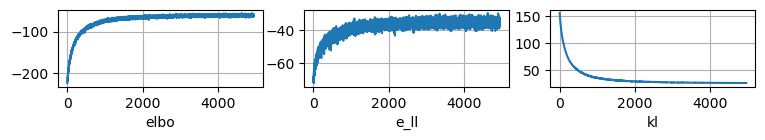

In [ ]:
svgp_prior = models.GPPrior(covariance_function='squared-exponential', num_inputs=2, l=0.25, train_l=False, sigma_f=2.5, train_sigma_f=False)
svgp = models.SparseVariationalGaussianProcess(x_dim=2, num_inducing=num_induc, likelihood=models.BernoulliLikelihood(), prior=svgp_prior)

svgp_training_metrics = train_gp(
    svgp,
    X_c,
    y_c,
    epochs=5_000,
    learning_rate=1e-3,
    final_learning_rate=1e-4,
    svgp=True,
    num_samples=5,
)

fig, axes = plt.subplots(1, len(svgp_training_metrics), figsize=(3*len(svgp_training_metrics), 1))
# if not isinstance(axes, list):
#     axes = [axes]
omitted_steps = 50
for i, (key, value) in enumerate(svgp_training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

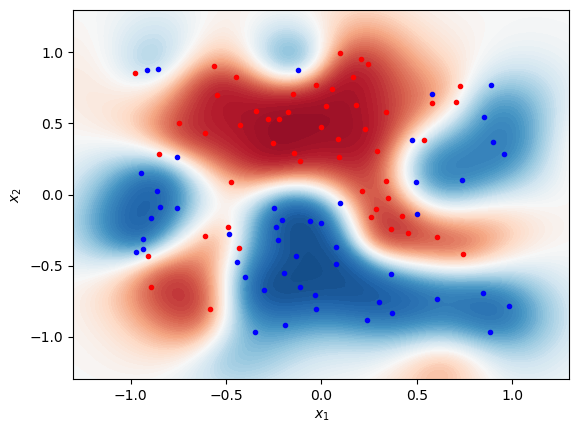

In [9]:
with torch.no_grad():
    preds = svgp(X_t, X_c, y_c).probs
    
preds_grid = preds.reshape_as(xx1)

plt.contourf(xx1, xx2, 1-preds_grid, torch.linspace(0.0, 1.0, 100), cmap='RdBu')
plt.scatter(X_c[:,0][t == 1], X_c[:,1][t == 1], color='red', marker='.', label='Class 1')
plt.scatter(X_c[:,0][t == 0], X_c[:,1][t == 0], color='blue', marker='.', label='Class 0')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([data_hypers['x_range'][0]*scope, data_hypers['x_range'][1]*scope])
plt.ylim([data_hypers['x_range'][0]*scope, data_hypers['x_range'][1]*scope])
# plt.grid()
plt.show()

In [ ]:
num_test_sets = 100
per_point_lls = torch.zeros((num_test_sets))


for i in tqdm(range(num_test_sets), disable=False):
    torch.manual_seed(i)
    X, y,  = obtain_me_a_nice_gp_dataset_please(n_range=[60, 300], **data_hypers)
    X_c, y_c, X_t, y_t = ctxt_trgt_split(X, y, ctxt_proportion_range=[0.45, 0.55])

    # svgp_prior = models.GPPrior(covariance_function='squared-exponential', num_inputs=2, l=0.25, train_l=False, sigma_f=2.5, train_sigma_f=False)
    # svgp = models.SparseVariationalGaussianProcess(x_dim=2, num_inducing=num_induc, likelihood=models.BernoulliLikelihood(), prior=svgp_prior)

    # svgp_training_metrics = train_gp(
    #     svgp,
    #     X_c,
    #     y_c,
    #     epochs=5_000,
    #     learning_rate=1e-3,
    #     final_learning_rate=1e-4,
    #     svgp=True,
    #     num_samples=5,
    #     silent=True,
    # )
    

    with torch.no_grad():
        # predictive = gnp(X_c, y_c, X_t)
        predictive = sconvsgnp(X_t, X_c, y_c)
        # predictive = convsgnp(X_t, X_c, y_c)
        per_point_lls[i] = predictive.log_prob(y_t.squeeze()).mean()

        # predictive = svgp(X_t, X_c, y_c)
        # per_point_lls[i] = predictive.log_prob(y_t.squeeze()).mean()


print(per_point_lls.mean(), per_point_lls.std())


100%|██████████| 100/100 [00:00<00:00, 133.46it/s]

tensor(-0.5802) tensor(0.0776)
